# Cats vs dogs

## Convnet example

### Data

The data is provided by kaggle, unfortunately the download link is not public, you will need to create an account at kaggle.com (it is free) and then download

https://www.kaggle.com/c/dogs-vs-cats/download/train.zip

Note that they file name is "train.zip" and it contains all the labeled data, we will need to split that into our train, validation and test set.

Once you have all the data, unzip it into a dir named "data" in the same directory of this jupyter notebook.


In [1]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2


print("Installed version of tensorflow is ", tf.__version__)
print("Important! tensorflow MUST be 1.2 or higher for this to work fine...")

Installed version of tensorflow is  1.2.1
Important! tensorflow MUST be 1.2 or higher for this to work fine...


In [2]:
# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

No GPU found. Please use a GPU to train your neural network.


In [3]:
FLOYDHUB=False
TRAIN=False # Switch if you want to actually train the code
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    DATA_DIR = "/input/"
    CLEANED_DATA_DIR = "/input/"
else:
    OUTPUT_DIR = "/tmp/"
    DATA_DIR = "data/augmented/"
    CLEANED_DATA_DIR = "data/augmented/"



### Explore the dataset

The definition of kaggle dataset is 

"The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)."

Notice! your direcory should look like this (once you have uncompressed the data)
```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
            ├── cat.2976.jpg
            ├── dog.2977.jpg
            ├── cat.2978.jpg
            ├── dog.2979.jpg
            ├── ...

```
Of course images named cat.xxx.jpg are cats and thesame goes for the ones started with dogs.

Lets open a few images


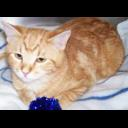

In [4]:

Image(filename=DATA_DIR+'cat.42.jpg')


Also, lets show a dog

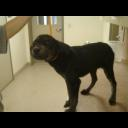

In [5]:
Image(filename=DATA_DIR+'dog.42.jpg')

The first obvious thing is that we are dealing here with images of different sizes, we need to make them the same size. Of course bigger sizes will mean more data, which means more processing time... For our example we will modify all images to be 100x100 pixels

In [6]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128

Lets read one cat image and transform it.

In [7]:
def resize_and_pad(img, size, padColor=0):
    # Credits goes to 
    # https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
                                    pad_left, pad_right, 
                                    borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [8]:
original = cv2.imread(DATA_DIR+'cat.42.jpg.flop')
resized = resize_and_pad(original, (IMAGE_HEIGHT, IMAGE_WIDTH))
print(resized.shape)


(128, 128, 3)


Seems fine... lets convince ourselves it is the same image by displaying it

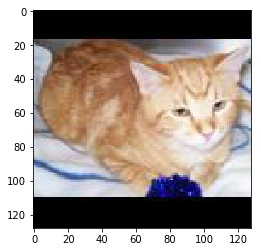

In [9]:
plt.imshow(resized)
plt.show()

The image has been resized, of course this means loosing some data, well, nobody is perfect :)
Now we will need to convert ALL our images and we will store them into a separated directory, we will use that directory for subsequent executions

In [10]:


try:
    mkdir(CLEANED_DATA_DIR)
except:
    pass

def convert_images():
    i = 1
    for image_file in listdir(DATA_DIR):
        if ".jpg" in image_file:
            original = cv2.imread(DATA_DIR+image_file)
            transformed = resize_and_pad(original, (IMAGE_WIDTH, IMAGE_HEIGHT))
            final_file = CLEANED_DATA_DIR+image_file
            imsave(final_file, transformed)
            if i % 500 == 0:
                print("Converted ", i, " images so far...")
            i += 1
    print("Done!")

In [11]:
if False:
    convert_images()

Now, we will read the new files and load them, we will load cats and dogs separately (just for convenience), then we will split them into train, validation and test set. 

* Train set 80% of the images
* Validation set 10% of the images
* Test set 10% of the images

In [12]:
CAT_LABEL = 1
DOG_LABEL = 0

def load_data(limit=None):
    """
    Gets all the data and returns
    X_train_cats, y_train_cats
    X_train_dogs, y_train_dogs
    X_validation_cats, y_validation_cats
    X_validation_dogs, y_validation_dogs
    X_test_cats, y_test_cats
    X_test_dogs, y_test_dogs
    """
    dogs = []
    cats = []
    i = 1
    if limit == None:
        limit = 60000
    expected_shape = (128, 128, 3)
    for image_file in listdir(CLEANED_DATA_DIR):        
        if ".jpg" in image_file:
            if "dog" in image_file and len(dogs) < limit:
                raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                if raw_image.shape != expected_shape:
                    print(CLEANED_DATA_DIR+image_file, "=>", raw_image.shape)
                else:
                    dogs.append(raw_image)
            elif "cat" in image_file and len(cats) < limit:
                raw_image = io.imread(CLEANED_DATA_DIR+image_file)
                if raw_image.shape != expected_shape:
                    print(CLEANED_DATA_DIR+image_file, "=>", raw_image.shape)
                else:
                    cats.append(raw_image)
        if i % 2500 == 0:
            print("Loaded ", i, " images so far...")
        i+=1    
            
    return cats, dogs

In [13]:
cats, dogs = load_data(1000)

Loaded  2500  images so far...
Loaded  5000  images so far...
Loaded  7500  images so far...
Loaded  10000  images so far...
Loaded  12500  images so far...
Loaded  15000  images so far...
Loaded  17500  images so far...
Loaded  20000  images so far...
Loaded  22500  images so far...
Loaded  25000  images so far...
Loaded  27500  images so far...
Loaded  30000  images so far...
Loaded  32500  images so far...
Loaded  35000  images so far...
Loaded  37500  images so far...
Loaded  40000  images so far...
Loaded  42500  images so far...
Loaded  45000  images so far...
Loaded  47500  images so far...
Loaded  50000  images so far...


Now we need to split our data into train, validation and test sets. As there are as many cats as there are dogs, we want to keep our sets balanced, with approximately 50% of cats and 50% of dogs. 

In [14]:
train_limit = int(len(cats) * 0.9)
validation_limit = train_limit + int(len(cats) * 0.05)

X_train_cats = np.array(cats[:train_limit])
X_train_dogs = np.array(dogs[:train_limit])
X_validation_cats = np.array(cats[train_limit:validation_limit])
X_validation_dogs = np.array(dogs[train_limit:validation_limit])
X_test_cats = np.array(cats[validation_limit:])
X_test_dogs = np.array(dogs[validation_limit:])

### Now we need to create our labels, remember that we have dined our labels as variables 
```
CAT_LABEL = 1
DOG_LABEL = 0
```

Meaning that cats are labelled as 1 and dogs as 0s

In [15]:
y_train_cats = np.ones(len(X_train_cats), dtype=np.int8)
y_train_dogs = np.zeros(len(X_train_dogs), dtype=np.int8)
y_validation_cats = np.ones(len(X_validation_cats), dtype=np.int8)
y_validation_dogs = np.zeros(len(X_validation_dogs), dtype=np.int8)
y_test_cats = np.ones(len(X_test_cats), dtype=np.int8)
y_test_dogs = np.zeros(len(X_test_dogs), dtype=np.int8)

y_train_cats.shape

(900,)

In [16]:
X_train = np.append(X_train_cats, X_train_dogs, axis=0)
y_train = np.append(y_train_cats, y_train_dogs)
X_validation = np.append(X_validation_cats, X_validation_dogs, axis=0)
y_validation = np.append(y_validation_cats, y_validation_dogs)
X_test = np.append(X_test_cats, X_test_dogs, axis=0)
y_test = np.append(y_test_cats, y_test_dogs)

del X_train_cats
del X_train_dogs
del X_test_cats
del X_test_dogs
del X_validation_cats
del X_validation_dogs
del y_train_cats
del y_train_dogs
del y_test_cats
del y_test_dogs
del y_validation_cats
del y_validation_dogs

### Lets convert labels into one-hot-encoded values

In [17]:
y_train = np.eye(2)[y_train.reshape(-1)]
y_validation = np.eye(2)[y_validation.reshape(-1)]
y_test = np.eye(2)[y_test.reshape(-1)]

### Now, lets make sure the arrays are in the correct shape

In [18]:
X_validation, y_validation = X_validation[0:1000], y_validation[0:1000]
X_test, y_test = X_test[0:1000], y_test[0:1000]
print("X_train ", X_train.shape, " y_train ", y_train.shape)
print("X_validation ", X_validation.shape, " y_validation ", y_validation.shape)
print("X_test ", X_test.shape, " y_test ", y_test.shape)

X_train  (1800, 128, 128, 3)  y_train  (1800, 2)
X_validation  (100, 128, 128, 3)  y_validation  (100, 2)
X_test  (100, 128, 128, 3)  y_test  (100, 2)


### And finally shuffle the arrays so that our batches are not all dogs or all cats

In [19]:
X_train, y_train = shuffle(X_train, y_train, 
                                            random_state=0)
X_validation, y_validation = shuffle(X_validation, y_validation, 
                                                           random_state=0)
X_test, y_test = shuffle(X_test, y_test, 
                                 random_state=0)

In [20]:
print(y_train[0:10])


[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


### Now, lets veryfy that we have shuffled correctly, we will display the first ten images of the train set and check that against the first 10 labels

[ 0.  1.]
This should be a cat...


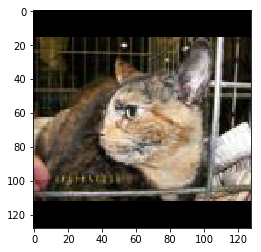

[ 0.  1.]
This should be a cat...


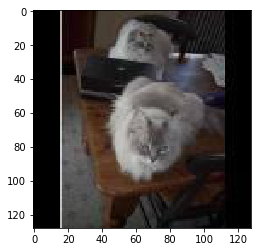

[ 1.  0.]
This should be a dog...


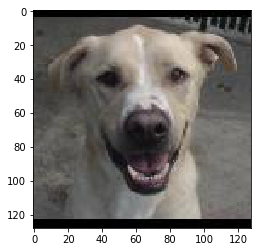

[ 0.  1.]
This should be a cat...


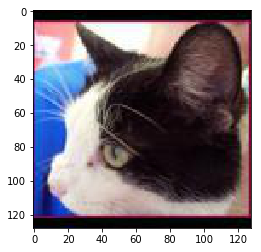

[ 1.  0.]
This should be a dog...


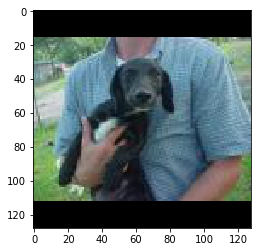

[ 1.  0.]
This should be a dog...


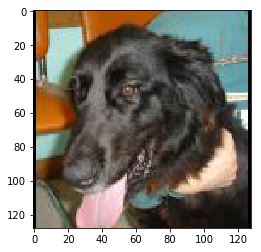

[ 1.  0.]
This should be a dog...


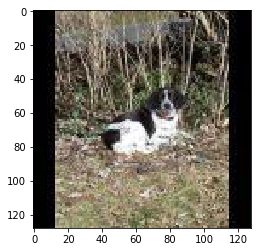

[ 0.  1.]
This should be a cat...


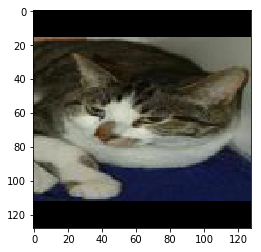

[ 0.  1.]
This should be a cat...


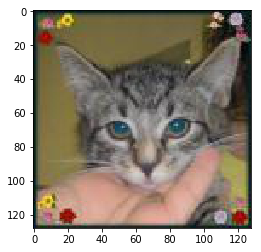

[ 1.  0.]
This should be a dog...


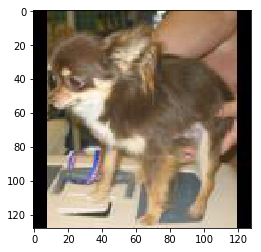

In [21]:
for i in range(10):
    label = y_train[i]
    print(label)
    if label[DOG_LABEL] == 1:
        print("This should be a dog...")
        
    elif label[CAT_LABEL] == 1:
        print("This should be a cat...")
    
    plt.imshow(X_train[i])
    plt.show()

### We still need to normalize our data, remember that normalization is done with the following formula
![title](normalization.png)

In [22]:
def normalize(raw_data):
    # TODO Figure this out
    # NOTE USE EITHER mean centering or min-max, NOT BOTH
    
    # Min and max values are 0 and 255
    raw_data = (raw_data - 0) / (255 - 0)
    
    # Mean centering
    #raw_data = (raw_data - raw_data.mean()) / raw_data.std()
    
    return raw_data


X_train = normalize(X_train)
X_validation = normalize(X_validation)
X_test = normalize(X_test)


In [23]:
del cats
del dogs

In [24]:
X_train[1].shape

(128, 128, 3)

### Machine learning! (at last!)

Things to do are

* Define hyperparameters
* Build the network itself
  * Placeholder definitions
  * Code perse
* Write the training code

In [25]:
def next_batch(X, y, batchSize):
    # loop over our dataset `X` in mini-batches of size `batchSize`
    for i in np.arange(0, X.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
        yield (X[i:i + batchSize,], y[i:i + batchSize,])

#### Define hyperparameters

In [26]:
FULLY_CONNECTED_LAYER_1 = 1024
FULLY_CONNECTED_LAYER_2 = 1024

# Convolutions are tuples of the form output, kernel, strides. Padding is always "SAME"
CONV_1_1 = (32, 3, 1) 
CONV_1_2 = (32, 3, 1)
CONV_2_1 = (64, 3, 1)
CONV_2_2 = (64, 3, 1)
CONV_3_1 = (128, 3, 1)
CONV_3_2 = (128, 3, 1)
CONV_4_1 = (256, 3, 1)
CONV_4_2 = (256, 3, 1)

# Pools are tuples of the form lernel size, strides VGG-16 uses strides of 2, not 3
POOL_1 = (2, 2) 
POOL_2 = (2, 2)
POOL_3_1 = (2, 2)
POOL_3_2 = (2, 2)
POOL_4_1 = (2, 2)
POOL_4_2 = (2, 2)

CONVOLUTION_1_OUTPUT = 16
CONVOLUTION_2_OUTPUT = 32
CONVOLUTION_3_OUTPUT = 64
CONVOLUTION_4_OUTPUT = 128
BATCH_SIZE = 16
EPOCHS = 10
dropout_training = 0.5

LABELS = 2 # Either cats or dogs
print("OK")

OK


#### Build the network itself

In [27]:
X = tf.placeholder(tf.float32, shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, 3), name="X")
y = tf.placeholder(tf.float32, shape=(None, LABELS), name="y")
dropout_rate = tf.placeholder(tf.float32, name="keep_prob")
is_training = tf.placeholder(tf.bool, name="is_training")

# First convolution, turn the image into 100x100xCONVOLUTION_1_OUTPUT
output, kernel, strides = CONV_1_1
print(output, kernel, strides)
convolution_1_1 = tf.layers.conv2d(X, output, kernel, strides, padding="SAME", activation=tf.nn.relu)

output, kernel, strides = CONV_1_2
print(output, kernel, strides)
convolution_1_2 = tf.layers.conv2d(convolution_1_1, output, kernel, strides, padding="SAME", activation=tf.nn.relu)

pool_kernel, pool_strides = POOL_1
pool_1 = tf.layers.max_pooling2d(convolution_1_2, pool_kernel, pool_strides, padding="SAME")

output, kernel, strides = CONV_2_1
print(output, kernel, strides)
convolution_2_1 = tf.layers.conv2d(pool_1, output, kernel, strides, padding="SAME", activation=tf.nn.relu)

output, kernel, strides = CONV_2_2
print(output, kernel, strides)
convolution_2_2 = tf.layers.conv2d(convolution_2_1, output, kernel, strides, padding="SAME", activation=tf.nn.relu)

pool_kernel, pool_strides = POOL_2
pool_2 = tf.layers.max_pooling2d(convolution_2_2, pool_kernel, pool_strides, padding="SAME")

output, kernel, strides = CONV_3_1
print(output, kernel, strides)
convolution_3_1 = tf.layers.conv2d(pool_2, output, kernel, strides, padding="SAME", activation=tf.nn.relu)
pool_kernel, pool_strides = POOL_3_1
pool_3_1 = tf.layers.max_pooling2d(convolution_3_1, pool_kernel, pool_strides, padding="SAME")

output, kernel, strides = CONV_3_2
print(output, kernel, strides)
convolution_3_2 = tf.layers.conv2d(convolution_3_1, output, kernel, strides, padding="SAME", activation=tf.nn.relu)
pool_kernel, pool_strides = POOL_3_2
pool_3_2 = tf.layers.max_pooling2d(convolution_3_2, pool_kernel, pool_strides, padding="SAME")



output, kernel, strides = CONV_4_1
print(output, kernel, strides)
convolution_4_1 = tf.layers.conv2d(pool_3_2, output, kernel, strides, padding="SAME", activation=tf.nn.relu)

pool_kernel, pool_strides = POOL_4_1
pool_4_1 = tf.layers.max_pooling2d(convolution_4_1, pool_kernel, pool_strides, padding="SAME")


output, kernel, strides = CONV_4_2
print(output, kernel, strides)
convolution_4_2 = tf.layers.conv2d(pool_4_1, output, kernel, strides, padding="SAME", activation=tf.nn.relu)
pool_kernel, pool_strides = POOL_4_2
pool_4_2 = tf.layers.max_pooling2d(convolution_4_2, pool_kernel, pool_strides, padding="SAME")








# So the output of the convolution is 12x12x32 = 4608, lets use that for a "normal" neural network

fully_connected_1 = tf.layers.dense(tf.reshape(pool_4_2, (-1, 4*4*256)),
                                FULLY_CONNECTED_LAYER_1, 
                                activation=tf.nn.relu)

fully_connected_1 = tf.layers.dropout(fully_connected_1, dropout_rate, training=is_training)

fully_connected_2 = tf.layers.dense(fully_connected_1,
                                FULLY_CONNECTED_LAYER_2, 
                                activation=tf.nn.relu)

fully_connected_2 = tf.layers.dropout(fully_connected_2, dropout_rate, training=is_training)

logits = tf.layers.dense(fully_connected_2, 
                              LABELS)  

predictions = tf.nn.softmax(logits, name="predictions-tensor")

softmax_calc = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
cost = tf.reduce_mean(softmax_calc)

train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)


#train_step = tf.train.AdamOptimizer().minimize(error)



32 3 1
32 3 1
64 3 1
64 3 1
128 3 1
128 3 1
256 3 1
256 3 1


#### Write the training code

In [ ]:
TOTAL_BATCHES = X_train.shape[0] // BATCH_SIZE
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())
last_accuracy = 0
start_at = 0
dropout_training = 0.5

saver = tf.train.Saver(tf.global_variables())

debug = True
for epoch_no in range(EPOCHS):
    
    for batch_no in range(TOTAL_BATCHES):
        start_at = batch_no
        slice_start = start_at*BATCH_SIZE
        slice_end = slice_start + BATCH_SIZE
        if slice_start > len(X_train) or slice_end > len(X_train):
            start_at = 0
            slice_start = start_at*BATCH_SIZE
            slice_end = slice_start + BATCH_SIZE
            print("From ", slice_start, "--", slice_end)
    
        
        my_X = X_train[slice_start:slice_end]
        my_y = y_train[slice_start:slice_end]
        
        my_X, my_y = shuffle(my_X, my_y)


        if debug:
            print("Convolution_1_1", convolution_1_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_1_2", convolution_1_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("pool_1", pool_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_2_1", convolution_2_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_2_2", convolution_2_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("pool_2", pool_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_3_1", convolution_3_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            printa("pool_3_1", pool_3_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_3_2", convolution_3_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("pool_3_2", pool_3_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            
            
            print("Convolution_4_1", convolution_4_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("pool_4_1", pool_4_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Convolution_4_2", convolution_4_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("pool_4_2", pool_4_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y}).shape)
            print("Fully connected_1", fully_connected_1.eval(feed_dict={X: my_X, 
                                                                 y: my_y,
                                                                dropout_rate: dropout_training,
                                                                        is_training:True}).shape)
            print("Fully connected_2", fully_connected_2.eval(feed_dict={X: my_X, 
                                                                 y: my_y,
                                                                dropout_rate: dropout_training,
                                                                        is_training:True}).shape)
            
            debug = False

        train_step.run(feed_dict={X: my_X, 
                                  y: my_y,
                                  dropout_rate: dropout_training,
                                  is_training:True})

        correct_prediction_val = tf.equal(tf.argmax(y_validation,1), tf.argmax(predictions, 1))
        accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))

        correct_prediction_train_batch = tf.equal(tf.argmax(my_y,1), tf.argmax(predictions, 1))
        accuracy_train_batch = tf.reduce_mean(tf.cast(correct_prediction_train_batch, tf.float32))
        if batch_no % 280 == 0:
            print("Batch", batch_no, "/", TOTAL_BATCHES, "completed...")
            print(" mini batch cost ", cost.eval(feed_dict={X: my_X, 
                                         y: my_y,
                                         dropout_rate: dropout_training,
                                          is_training:False}),
                  "\tmini batch (train) accuracy", accuracy_train_batch.eval(feed_dict={X: my_X, 
                                                                   y: my_y,
                                                                   dropout_rate: dropout_training,
                                          is_training:False}))
            
    
    print("============================================================")
    print("Epoch ", epoch_no, 
          " batch number ", batch_no, 
          
          "\t validation cost ", cost.eval(feed_dict={X: X_validation, 
                                         y: y_validation,
                                         dropout_rate: dropout_training,
                                          is_training:False}),
          " \tval accuracy ", accuracy_val.eval(feed_dict={X: X_validation, 
                                                           y: y_validation,
                                                           dropout_rate: dropout_training,
                                          is_training:False}),
          )
    print("Save to " + OUTPUT_DIR + "model_epoch_%d_batch_%d" % (epoch_no, batch_no))
    saver.save(session, OUTPUT_DIR + "model_epoch_%d_batch_%d" % (epoch_no, batch_no))
    print("============================================================")
        
print("DONE!!")

In [31]:
def evaluate_model(cost, X_test, y_test, debug=True):
    correct_prediction_test = tf.equal(tf.argmax(y_test,1), tf.argmax(predictions, 1))
    accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32))
    model_cost = cost.eval(feed_dict={X: X_test, 
                                         y: y_test,
                                         dropout_rate: dropout_training,
                                          is_training:False})
    model_accuracy = accuracy_test.eval(feed_dict={X: X_test, 
                                                           y: y_test,
                                                           dropout_rate: dropout_training,
                                          is_training:False})
    if debug:
        print("============================================================")
        print(
              "\t Test cost ", model_cost,
              " \\tTest accuracy ", model_accuracy,
              )
        print("============================================================")
    return model_cost, model_accuracy

evaluate_model(cost, X_test, y_test)    

	 Test cost  0.438995  \tTest accuracy  0.8


(0.43899521, 0.80000001)

## Perform predictions

['floyd_50000_model_epoch_0_batch_1404', 'floyd_50000_model_epoch_1_batch_1404', 'floyd_model_epoch_0_batch_69', 'floyd_model_epoch_1_batch_69', 'floyd_model_epoch_2_batch_69', 'floyd_model_epoch_3_batch_69', 'floyd_model_epoch_4_batch_69', 'floyd_model_epoch_5_batch_69', 'floyd_model_epoch_6_batch_69', 'floyd_model_epoch_7_batch_69', 'floyd_model_epoch_8_batch_69']
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_50000_model_epoch_0_batch_1404

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_50000_model_epoch_0_batch_1404
	Cost  0.438995
	Accuracy  0.8


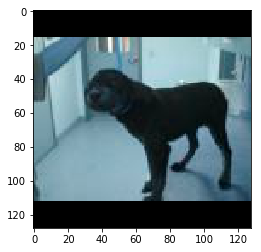

(1, 2)


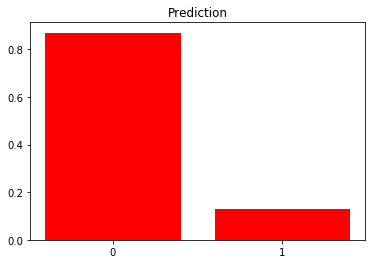

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_50000_model_epoch_1_batch_1404

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_50000_model_epoch_1_batch_1404
	Cost  0.220252
	Accuracy  0.94


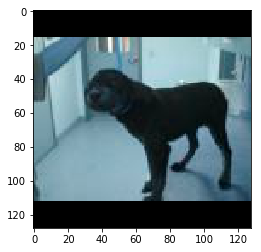

(1, 2)


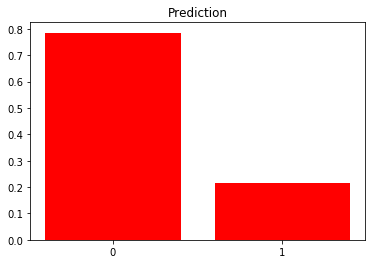

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_0_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_0_batch_69
	Cost  0.676706
	Accuracy  0.61


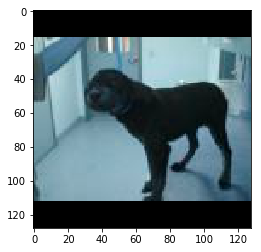

(1, 2)


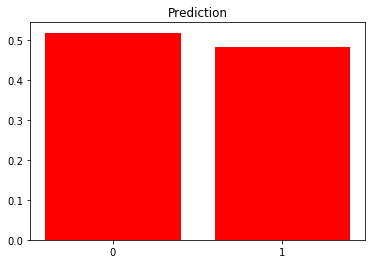

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_1_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_1_batch_69
	Cost  0.648279
	Accuracy  0.63


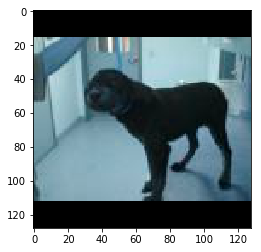

(1, 2)


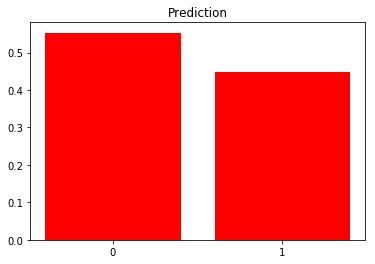

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_2_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_2_batch_69
	Cost  0.617747
	Accuracy  0.69


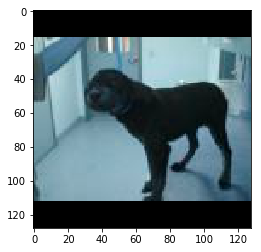

(1, 2)


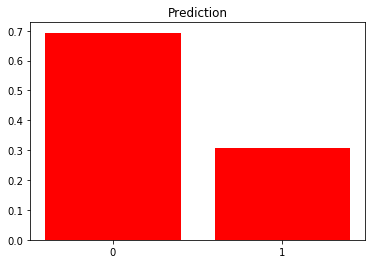

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_4_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_4_batch_69
	Cost  0.565819
	Accuracy  0.72


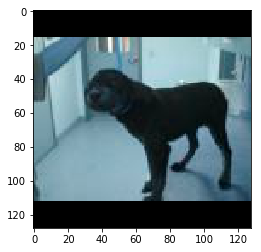

(1, 2)


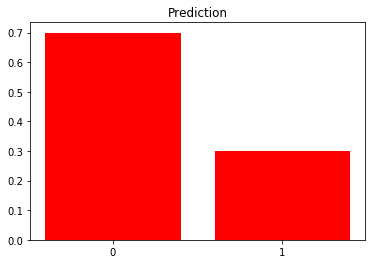

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_5_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_5_batch_69
	Cost  0.517391
	Accuracy  0.76


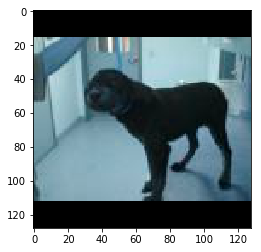

(1, 2)


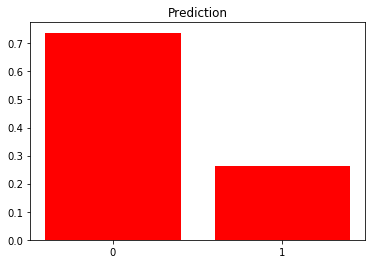

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_6_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_6_batch_69
	Cost  0.493863
	Accuracy  0.77


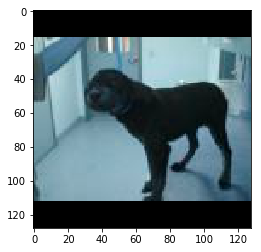

(1, 2)


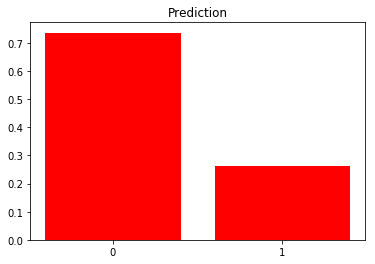

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_7_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_7_batch_69
	Cost  0.447057
	Accuracy  0.77


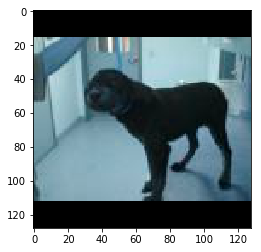

(1, 2)


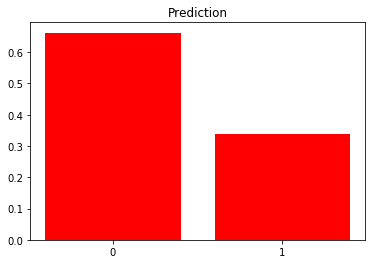

-------------------------------
INFO:tensorflow:Restoring parameters from /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_8_batch_69

-------------------------------
Evaluate model /home/moriano/Desktop/catsvsdogs/floyd_model_epoch_8_batch_69
	Cost  0.412351
	Accuracy  0.82


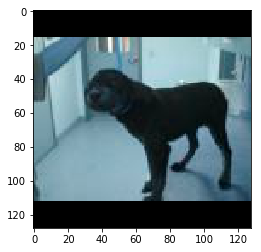

(1, 2)


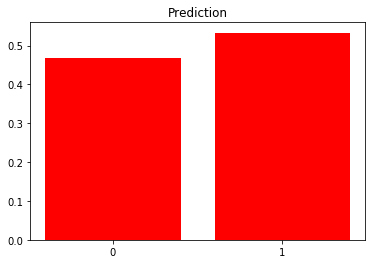

-------------------------------
DONE


In [36]:
#del session
#session.close()
MODELS_DIR = "/home/moriano/Desktop/catsvsdogs/"
MODEL_FILES = []
for model_file_raw in listdir(MODELS_DIR):
    if ".meta" in model_file_raw:
        MODEL_FILES.append(model_file_raw.replace(".meta", ""))
print(sorted(MODEL_FILES))   

for model_file in sorted(MODEL_FILES[1:]):
    model_file = MODELS_DIR + model_file #OUTPUT_DIR + "model_epoch_0_batch_6"
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, model_file)
    
    model_cost, model_accuracy = evaluate_model(cost, X_test, y_test, debug=False)
    print("\n-------------------------------")
    print("Evaluate model " + model_file)
    print("\tCost ", model_cost)
    print("\tAccuracy ", model_accuracy)
    perform_prediction(DATA_DIR+"/dog.42.jpg", predictions)
    print("-------------------------------")

print("DONE")    

In [ ]:
print(predictions)
print(X_test.shape)

In [34]:
def perform_prediction(file_name, predictions_tensor):
    resized = np.empty((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Prepare array to store image
        
    #Read image, reshape it and display it
    raw_image = cv2.imread(file_name)
    resized_image = cv2.resize(raw_image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.imshow(resized_image)
    plt.show()
    
    # Reshape again to 28*28, normalize and perform prediction
    resized[0] = resized_image
    
    normalized = (resized - 0) / (255 - 0)
    predicted = predictions_tensor.eval(feed_dict={X: normalized, dropout_rate: dropout_training,
                                                                        is_training:False})
    # Plot the predictions
    # Remember
    # CAT_LABEL = 1
    # DOG_LABEL = 0
    possible_answers = [0, 1]
    my_prediction = predicted[0, :]    
    print(predicted.shape)
    plt.bar(possible_answers, my_prediction, color="red")
    plt.xticks(possible_answers, possible_answers)
    plt.title("Prediction")
    plt.show()

   
  

In [ ]:
for i in range(25):
    perform_prediction(DATA_DIR+"/dog.2%d.jpg" % i, predictions)
    print("----------------------------------------------------------------------")
    
print("----------------------------------------------------------------------")
print("----------------------------------------------------------------------")
print("----------------------------------------------------------------------")
print("----------------------------------------------------------------------")
print("----------------------------------------------------------------------")

for i in range(25):
    perform_prediction(DATA_DIR+"/cat.2%d.jpg" % i, predictions)
    print("----------------------------------------------------------------------")    